In [1]:
import numpy as np
import pandas as pd
import datetime
import gc
from itertools import combinations

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/narimatsu_n/.pyenv/versions/3.5.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df_train = pd.read_csv("../input/20181216_train.csv")
df_test = pd.read_csv("../input/20181216_test.csv")

In [3]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [4]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/city_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")

df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")

df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")

df_train, df_test = merge_new_feature("../input/feature_various_time_data.csv")
df_train, df_test = merge_new_feature("../input/feature_term_from_second_latest_to_latest.csv")
df_train, df_test = merge_new_feature("../input/feature_purchase_num__per__purchase_month_count_rate.csv")
df_train, df_test = merge_new_feature("../input/feature_payment_each_month_splited_by_installments.csv")

In [5]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [6]:
df_train_columns = [c for c in df_train.columns if c not in ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers']]
target = df_train['target']
target_outlier = df_train["outliers"]

In [7]:
max_each_col = np.max(df_train[df_train_columns].values, axis=0)

for i, max_ in enumerate(max_each_col):
    if max_ >= 1e+7:
        df_train[df_train_columns[i]] = 1/(1+np.exp(-1*df_train[df_train_columns[i]].values))
        df_test[df_train_columns[i]] = 1/(1+np.exp(-1*df_test[df_train_columns[i]].values))

In [8]:
drop_col = []
comb = list(combinations(df_train_columns, 2))

for c1, c2 in comb:
    corr = np.corrcoef(df_train[c1], df_train[c2])[0,1]
    if corr >= 0.962:
        print("【{i}】 --- 【{j}】".format(i=c1, j=c2))
        print(corr)
        drop_col.append(c2)
        print("\n"*2)

for col in df_train_columns:
    if col in sorted(set(drop_col)):
        df_train_columns.remove(col)

【hist_authorized_flag_sum】 --- 【hist_card_id_size】
0.9945716227736431



【hist_authorized_flag_sum】 --- 【sales_lag3_div_lag_6_sum】
0.991252479458827



【hist_authorized_flag_sum】 --- 【sales_lag6_div_lag_12_sum】
0.9903479752948366



【hist_authorized_flag_sum】 --- 【puchases_lag3_div_lag_6_sum】
0.9914139390387703



【hist_authorized_flag_sum】 --- 【puchases_lag6_div_lag_12_sum】
0.9903376928990004



【hist_card_id_size】 --- 【sales_lag3_div_lag_6_sum】
0.9975144605006232



【hist_card_id_size】 --- 【sales_lag6_div_lag_12_sum】
0.9968560102554356



【hist_card_id_size】 --- 【puchases_lag3_div_lag_6_sum】
0.9976116876313735



【hist_card_id_size】 --- 【puchases_lag6_div_lag_12_sum】
0.9967725640779598



【hist_purchase_date_diff】 --- 【purchase_term】
0.968714472679401



【hist_purchase_date_diff】 --- 【elapsed_from_oldest_purchase_date_to_latest_purchase_date】
0.968714472679401



【new_hist_purchase_date_max】 --- 【new_hist_purchase_date_min】
1.0



【hist_first_buy】 --- 【elapsed_from_oldest_purchase_da

In [9]:
sorted(set(drop_col))

['NMF_comp_purchase_amount_1',
 'NMF_comp_purchase_amount_10',
 'NMF_comp_purchase_amount_2',
 'NMF_comp_purchase_amount_3',
 'NMF_comp_purchase_amount_4',
 'NMF_comp_purchase_amount_5',
 'NMF_comp_purchase_amount_6',
 'NMF_comp_purchase_amount_7',
 'NMF_comp_purchase_amount_8',
 'NMF_comp_purchase_amount_9',
 'elapsed_from_oldest_purchase_date_to_first_active',
 'elapsed_from_oldest_purchase_date_to_latest_purchase_date',
 'elapsed_third_absolute',
 'hist_card_id_size',
 'new_hist_purchase_date_min',
 'puchases_lag3_div_lag_6_sum',
 'puchases_lag6_div_lag_12_sum',
 'purchase_term',
 'relu_numerical_pca_max',
 'relu_numerical_pca_mean',
 'relu_numerical_pca_std',
 'relu_numerical_pca_sum',
 'sales_lag3_div_lag_6_sum',
 'sales_lag6_div_lag_12_sum']

In [10]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    "max_bin": 256,  # なし
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73691	valid_1's rmse: 3.77505
[200]	training's rmse: 3.66699	valid_1's rmse: 3.73311
[300]	training's rmse: 3.6177	valid_1's rmse: 3.70935
[400]	training's rmse: 3.57946	valid_1's rmse: 3.69423
[500]	training's rmse: 3.5492	valid_1's rmse: 3.68384
[600]	training's rmse: 3.52376	valid_1's rmse: 3.6757
[700]	training's rmse: 3.50279	valid_1's rmse: 3.67102
[800]	training's rmse: 3.4838	valid_1's rmse: 3.66671
[900]	training's rmse: 3.46698	valid_1's rmse: 3.66337
[1000]	training's rmse: 3.45118	valid_1's rmse: 3.66053
[1100]	training's rmse: 3.43631	valid_1's rmse: 3.65835
[1200]	training's rmse: 3.42226	valid_1's rmse: 3.65621
[1300]	training's rmse: 3.40944	valid_1's rmse: 3.65414
[1400]	training's rmse: 3.39696	valid_1's rmse: 3.65261
[1500]	training's rmse: 3.38525	valid_1's rmse: 3.65115
[1600]	training's rmse: 3.37391	valid_1's rmse: 3.65011
[1700]	training's rmse: 3.3631	valid_1's rmse: 

[1100]	training's rmse: 3.42897	valid_1's rmse: 3.67052
[1200]	training's rmse: 3.41475	valid_1's rmse: 3.66959
[1300]	training's rmse: 3.40112	valid_1's rmse: 3.66869
[1400]	training's rmse: 3.38842	valid_1's rmse: 3.66793
[1500]	training's rmse: 3.37681	valid_1's rmse: 3.66723
[1600]	training's rmse: 3.36538	valid_1's rmse: 3.66685
[1700]	training's rmse: 3.35435	valid_1's rmse: 3.66632
[1800]	training's rmse: 3.34366	valid_1's rmse: 3.66605
[1900]	training's rmse: 3.33334	valid_1's rmse: 3.6656
[2000]	training's rmse: 3.3232	valid_1's rmse: 3.66539
[2100]	training's rmse: 3.31363	valid_1's rmse: 3.6652
[2200]	training's rmse: 3.30416	valid_1's rmse: 3.6652
[2300]	training's rmse: 3.29496	valid_1's rmse: 3.66497
[2400]	training's rmse: 3.28628	valid_1's rmse: 3.6647
[2500]	training's rmse: 3.2776	valid_1's rmse: 3.66423
[2600]	training's rmse: 3.26866	valid_1's rmse: 3.66397
[2700]	training's rmse: 3.26019	valid_1's rmse: 3.66382
[2800]	training's rmse: 3.25193	valid_1's rmse: 3.6636

3.644427050221759

In [11]:
# score:  3.6467757129353053

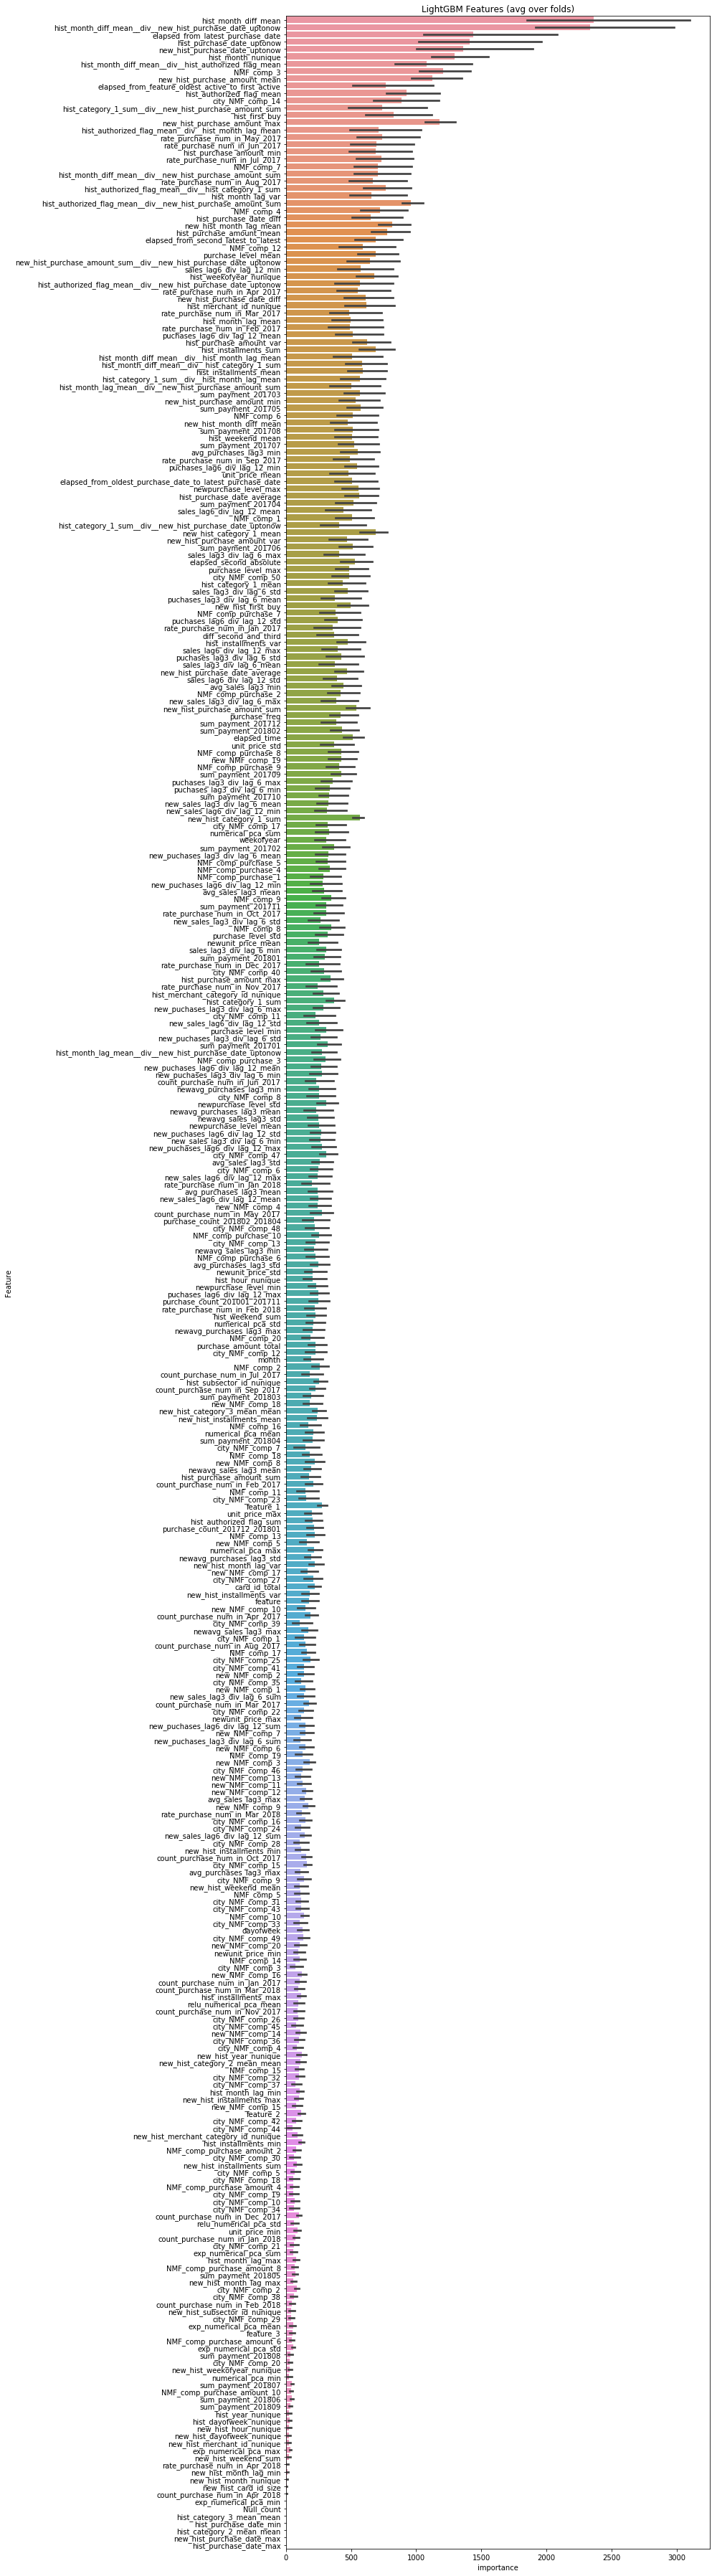

In [12]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [13]:
df_train_columns2 = cols[:200]

param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    "max_bin": 256,  # なし
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns2], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns2], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns2], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73721	valid_1's rmse: 3.7742
[200]	training's rmse: 3.66733	valid_1's rmse: 3.73188
[300]	training's rmse: 3.6182	valid_1's rmse: 3.70816
[400]	training's rmse: 3.58095	valid_1's rmse: 3.69308
[500]	training's rmse: 3.55106	valid_1's rmse: 3.68176
[600]	training's rmse: 3.52577	valid_1's rmse: 3.67374
[700]	training's rmse: 3.50485	valid_1's rmse: 3.66861
[800]	training's rmse: 3.48624	valid_1's rmse: 3.66434
[900]	training's rmse: 3.46998	valid_1's rmse: 3.66117
[1000]	training's rmse: 3.45443	valid_1's rmse: 3.65846
[1100]	training's rmse: 3.43995	valid_1's rmse: 3.65615
[1200]	training's rmse: 3.42656	valid_1's rmse: 3.65441
[1300]	training's rmse: 3.41394	valid_1's rmse: 3.65325
[1400]	training's rmse: 3.40155	valid_1's rmse: 3.6517
[1500]	training's rmse: 3.38987	valid_1's rmse: 3.6504
[1600]	training's rmse: 3.37871	valid_1's rmse: 3.64953
[1700]	training's rmse: 3.36824	valid_1's rmse:

[1700]	training's rmse: 3.35539	valid_1's rmse: 3.66606
[1800]	training's rmse: 3.34441	valid_1's rmse: 3.66574
[1900]	training's rmse: 3.33409	valid_1's rmse: 3.66545
[2000]	training's rmse: 3.3239	valid_1's rmse: 3.66503
[2100]	training's rmse: 3.3142	valid_1's rmse: 3.66469
[2200]	training's rmse: 3.30478	valid_1's rmse: 3.66435
[2300]	training's rmse: 3.2956	valid_1's rmse: 3.6641
[2400]	training's rmse: 3.28706	valid_1's rmse: 3.6639
[2500]	training's rmse: 3.27866	valid_1's rmse: 3.66353
[2600]	training's rmse: 3.26991	valid_1's rmse: 3.66337
[2700]	training's rmse: 3.26157	valid_1's rmse: 3.66316
[2800]	training's rmse: 3.25325	valid_1's rmse: 3.663
[2900]	training's rmse: 3.24555	valid_1's rmse: 3.66277
[3000]	training's rmse: 3.23729	valid_1's rmse: 3.66262
[3100]	training's rmse: 3.22971	valid_1's rmse: 3.66226
[3200]	training's rmse: 3.22222	valid_1's rmse: 3.66207
[3300]	training's rmse: 3.21511	valid_1's rmse: 3.66201
[3400]	training's rmse: 3.20767	valid_1's rmse: 3.66193

3.642592563086299

In [14]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.60672	valid_1's rmse: 1.60657
[200]	training's rmse: 1.57512	valid_1's rmse: 1.57822
[300]	training's rmse: 1.55959	valid_1's rmse: 1.56715
[400]	training's rmse: 1.54884	valid_1's rmse: 1.56148
[500]	training's rmse: 1.54016	valid_1's rmse: 1.55809
[600]	training's rmse: 1.53281	valid_1's rmse: 1.55593
[700]	training's rmse: 1.52628	valid_1's rmse: 1.55472
[800]	training's rmse: 1.5203	valid_1's rmse: 1.554
[900]	training's rmse: 1.51489	valid_1's rmse: 1.55351
[1000]	training's rmse: 1.50965	valid_1's rmse: 1.5531
[1100]	training's rmse: 1.50475	valid_1's rmse: 1.55281
[1200]	training's rmse: 1.50004	valid_1's rmse: 1.55263
[1300]	training's rmse: 1.49545	valid_1's rmse: 1.55247
[1400]	training's rmse: 1.49101	valid_1's rmse: 1.55227
[1500]	training's rmse: 1.48678	valid_1's rmse: 1.55214
[1600]	training's rmse: 1.48248	valid_1's rmse: 1.55206
[1700]	training's rmse: 1.4783	valid_1's rmse: 

[800]	training's rmse: 1.51517	valid_1's rmse: 1.58009
[900]	training's rmse: 1.50968	valid_1's rmse: 1.57948
[1000]	training's rmse: 1.5045	valid_1's rmse: 1.57907
[1100]	training's rmse: 1.49953	valid_1's rmse: 1.57875
[1200]	training's rmse: 1.49479	valid_1's rmse: 1.57853
[1300]	training's rmse: 1.49019	valid_1's rmse: 1.57836
[1400]	training's rmse: 1.48572	valid_1's rmse: 1.57826
[1500]	training's rmse: 1.4814	valid_1's rmse: 1.5782
[1600]	training's rmse: 1.47723	valid_1's rmse: 1.5781
[1700]	training's rmse: 1.47295	valid_1's rmse: 1.57796
[1800]	training's rmse: 1.46882	valid_1's rmse: 1.57788
[1900]	training's rmse: 1.46476	valid_1's rmse: 1.57782
[2000]	training's rmse: 1.46079	valid_1's rmse: 1.57777
[2100]	training's rmse: 1.45683	valid_1's rmse: 1.57772
[2200]	training's rmse: 1.45288	valid_1's rmse: 1.57773
[2300]	training's rmse: 1.44894	valid_1's rmse: 1.57768
[2400]	training's rmse: 1.44506	valid_1's rmse: 1.57767
[2500]	training's rmse: 1.44118	valid_1's rmse: 1.5776

1.5570711301959101

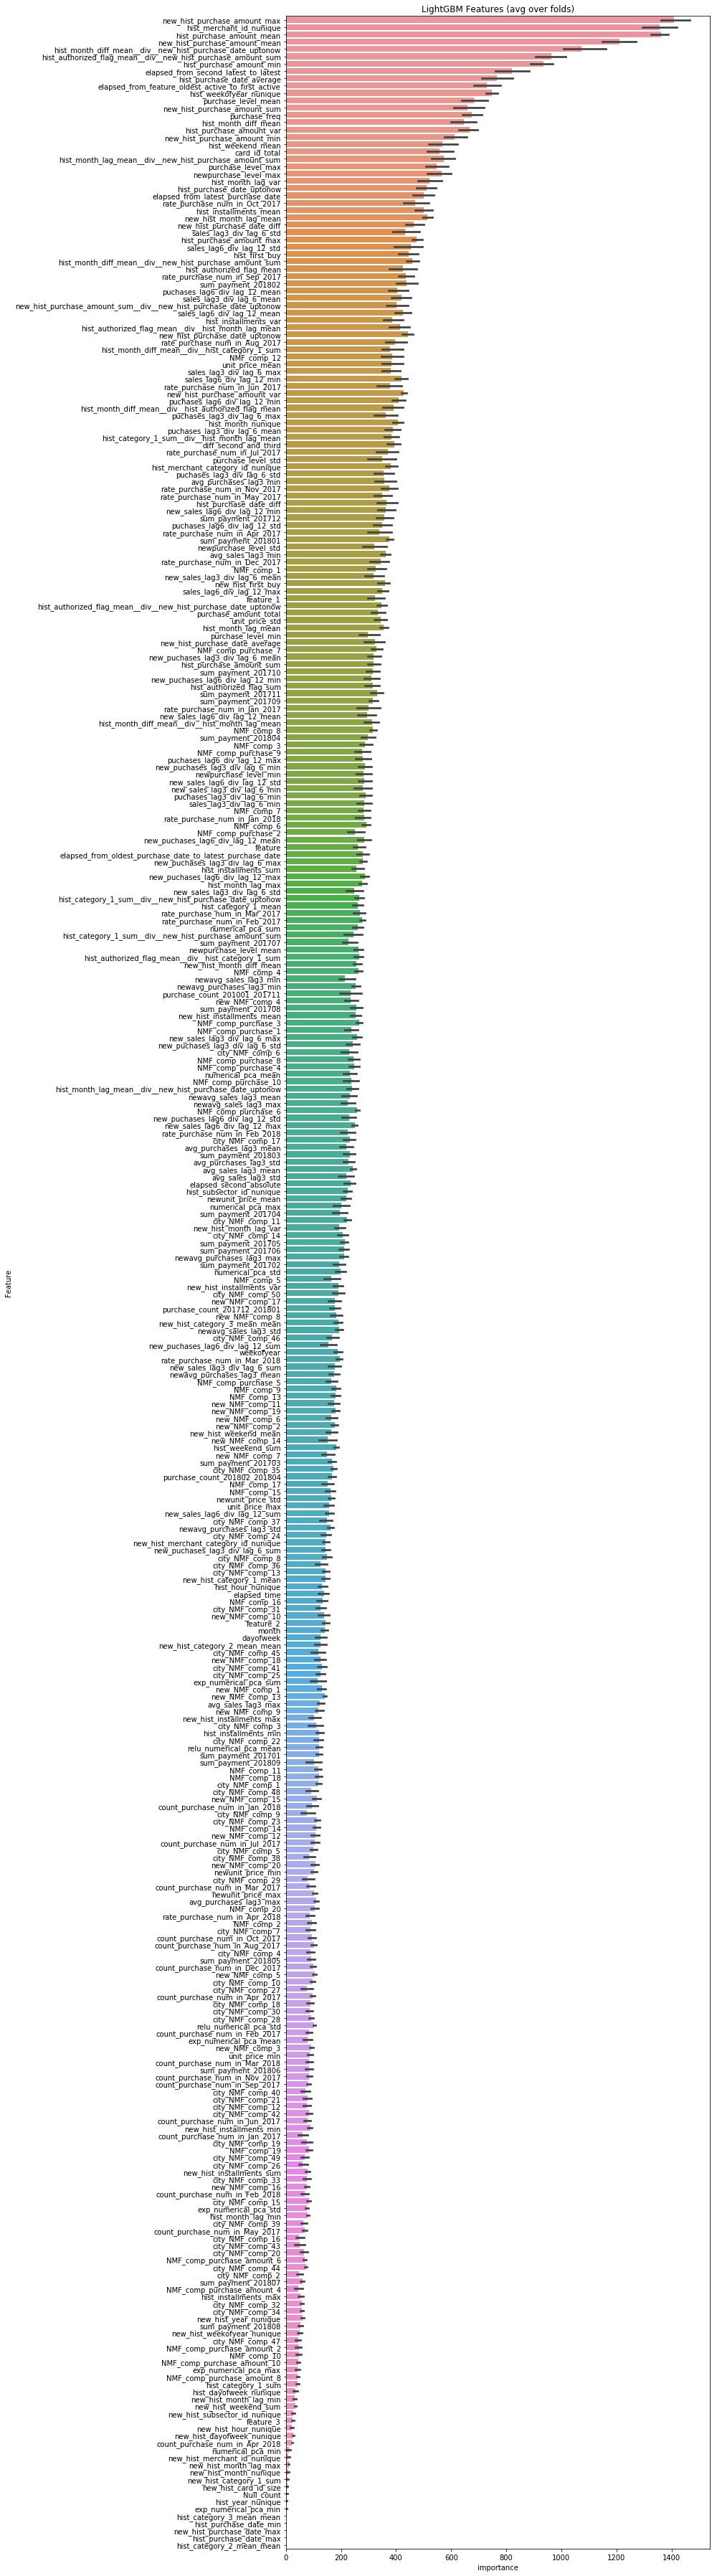

In [15]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [16]:
df_train_columns3 = cols[:200]

df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns3], label=target2.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns3], label=target2.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns3], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns3
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns3], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.60674	valid_1's rmse: 1.60627
[200]	training's rmse: 1.57531	valid_1's rmse: 1.57781
[300]	training's rmse: 1.55987	valid_1's rmse: 1.56684
[400]	training's rmse: 1.54924	valid_1's rmse: 1.56111
[500]	training's rmse: 1.54077	valid_1's rmse: 1.55776
[600]	training's rmse: 1.53352	valid_1's rmse: 1.5556
[700]	training's rmse: 1.5271	valid_1's rmse: 1.55414
[800]	training's rmse: 1.52128	valid_1's rmse: 1.55326
[900]	training's rmse: 1.51598	valid_1's rmse: 1.55278
[1000]	training's rmse: 1.51073	valid_1's rmse: 1.55232
[1100]	training's rmse: 1.50594	valid_1's rmse: 1.55198
[1200]	training's rmse: 1.50147	valid_1's rmse: 1.55169
[1300]	training's rmse: 1.49692	valid_1's rmse: 1.55145
[1400]	training's rmse: 1.49249	valid_1's rmse: 1.55135
[1500]	training's rmse: 1.48819	valid_1's rmse: 1.55115
[1600]	training's rmse: 1.48386	valid_1's rmse: 1.55105
[1700]	training's rmse: 1.47964	valid_1's rms

[100]	training's rmse: 1.60082	valid_1's rmse: 1.63054
[200]	training's rmse: 1.56943	valid_1's rmse: 1.60371
[300]	training's rmse: 1.55409	valid_1's rmse: 1.59305
[400]	training's rmse: 1.5436	valid_1's rmse: 1.58752
[500]	training's rmse: 1.53518	valid_1's rmse: 1.5842
[600]	training's rmse: 1.52793	valid_1's rmse: 1.58191
[700]	training's rmse: 1.52163	valid_1's rmse: 1.58067
[800]	training's rmse: 1.51581	valid_1's rmse: 1.57981
[900]	training's rmse: 1.51058	valid_1's rmse: 1.57931
[1000]	training's rmse: 1.50546	valid_1's rmse: 1.57886
[1100]	training's rmse: 1.50066	valid_1's rmse: 1.57857
[1200]	training's rmse: 1.4958	valid_1's rmse: 1.57841
[1300]	training's rmse: 1.49128	valid_1's rmse: 1.57823
[1400]	training's rmse: 1.48682	valid_1's rmse: 1.57805
[1500]	training's rmse: 1.48255	valid_1's rmse: 1.57795
[1600]	training's rmse: 1.47831	valid_1's rmse: 1.57779
[1700]	training's rmse: 1.47422	valid_1's rmse: 1.57767
[1800]	training's rmse: 1.47015	valid_1's rmse: 1.57764
[190

1.556708837951746

In [17]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2":predictions2})
df_prediction

,prediction1,prediction2
0,-1.903370,-0.452360
1,-0.265276,-0.270233
2,-1.021379,-0.411685
3,-0.079277,-0.132197
4,-1.571814,-1.822170
5,0.041476,0.634004
6,0.068140,0.085537
7,0.510015,0.862759
8,-0.641784,-0.620665
9,-0.870340,-0.167225


In [18]:
predictions3 = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0 :
        predictions3[i] = r[0]
    else:
        predictions3[i] = r[1]
df_prediction["prediction3"] = predictions3

In [19]:
df_prediction

,prediction1,prediction2,prediction3
0,-1.903370,-0.452360,-1.903370
1,-0.265276,-0.270233,-0.265276
2,-1.021379,-0.411685,-1.021379
3,-0.079277,-0.132197,-0.079277
4,-1.571814,-1.822170,-1.571814
5,0.041476,0.634004,0.634004
6,0.068140,0.085537,0.085537
7,0.510015,0.862759,0.862759
8,-0.641784,-0.620665,-0.641784
9,-0.870340,-0.167225,-0.870340


In [20]:
final_predictions = df_prediction.prediction3.values

In [21]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = final_predictions
sub_df.to_csv("../output/submission_base_model20190202.csv", index=False)